In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Ideal Filter
def ideal_filter(img, cutoff):
    # Perform Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = fshift.shape
    mask = np.zeros((rows, cols), dtype='float')

    crow, ccol = rows / 2, cols / 2

    # Create ideal filter mask
    for i in range(rows):
        for j in range(cols):
            c = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
            if c <= cutoff:
                mask[i, j] = 1
            else:
                mask[i, j] = 0

    # Apply the mask to the frequency domain
    fshift = fshift * mask

    # Perform inverse Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    # Normalize pixel values
    img_filtered = img_filtered / np.max(img_filtered) * 255
    img_filtered = img_filtered.astype(np.uint8)

    return img_filtered

In [3]:
# Butterworth Filter
def butterworth_filter(img, cutoff, order):
    # Perform Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = fshift.shape
    crow, ccol = rows / 2, cols / 2
    mask = np.zeros((rows, cols), dtype='float')

    # Create Butterworth filter mask
    for i in range(rows):
        for j in range(cols):
            mask[i, j] = 1 / (1 + ((np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)) / cutoff) ** (2 * order))

    # Apply the mask to the frequency domain
    fshift = fshift * mask

    # Perform inverse Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    # Normalize pixel values
    img_filtered = img_filtered / np.max(img_filtered) * 255
    img_filtered = img_filtered.astype(np.uint8)

    return img_filtered


In [4]:
# Gaussian Filter
def gaussian_filter(img, sigma):
    # Perform Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = fshift.shape
    crow, ccol = rows / 2, cols / 2
    mask = np.zeros((rows, cols), dtype='float')

    # Create Gaussian filter mask
    for i in range(rows):
        for j in range(cols):
            mask[i, j] = np.exp(-((i - crow) ** 2 + (j - ccol) ** 2) / (2 * sigma ** 2))

    # Apply the mask to the frequency domain
    fshift = fshift * mask

    # Perform inverse Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    # Normalize pixel values
    img_filtered = img_filtered / np.max(img_filtered) * 255
    img_filtered = img_filtered.astype(np.uint8)

    return img_filtered

In [5]:
# Load input image
img = cv2.imread('img/image.jpg', 0)

In [6]:
# Create face masks
all_face = np.zeros_like(img)
all_face = cv2.ellipse(all_face, (315, 210), (120, 170), 0, 0, 360, 255, -1)

face_mask = np.zeros_like(img)
cv2.ellipse(face_mask, (250, 172), (42, 32), 0, 0, 360, 255, -1)
cv2.ellipse(face_mask, (380, 172), (42, 32), 0, 0, 360, 255, -1)
cv2.ellipse(face_mask, (315, 310), (45, 15), 0, 0, 360, 255, -1)
cv2.circle(face_mask, (300, 265), 6, 255, -1)
cv2.circle(face_mask, (330, 265), 6, 255, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
# Apply area filter to combine filtered regions with the original image
def area_filter(filtered_img):
    rows, cols = img.shape
    mask_img = np.zeros((rows, cols), dtype='float')
    for i in range(rows):
        for j in range(cols):
            if(all_face[i, j] == 255 and face_mask[i, j] != 255):
                mask_img[i, j] = filtered_img[i, j]
            else:
                mask_img[i, j] = img[i, j]
    return mask_img

In [8]:
# Apply filters
cutoff_frequency = 35
ideal_filtered = area_filter(ideal_filter(img, cutoff_frequency))

cutoff_frequency = 25
order = 2
butterworth_filtered = area_filter(butterworth_filter(img, cutoff_frequency, order))

sigma = 25
gaussian_filtered = area_filter(gaussian_filter(img, sigma))

In [9]:
# Combine filtered images
ideal_butterworth_filtered = area_filter((ideal_filtered + butterworth_filtered) / 2)
butterworth_gaussian_filtered = area_filter((butterworth_filtered + gaussian_filtered) / 2)
ideal_gaussian_filtered = area_filter((ideal_filtered + gaussian_filtered) / 2)
img_filtered = area_filter((ideal_filtered + butterworth_filtered + gaussian_filtered) / 3)

In [10]:
# Save filtered images
cv2.imwrite('img/ideal.jpg', ideal_filtered)
cv2.imwrite('img/butterworth.jpg', butterworth_filtered)
cv2.imwrite('img/gaussian.jpg', gaussian_filtered)
cv2.imwrite('img/ideal_butterworth.jpg', ideal_butterworth_filtered)
cv2.imwrite('img/butterworth_gaussian.jpg', butterworth_gaussian_filtered)
cv2.imwrite('img/ideal_gaussian.jpg', ideal_gaussian_filtered)
cv2.imwrite('img/all.jpg', img_filtered)

True

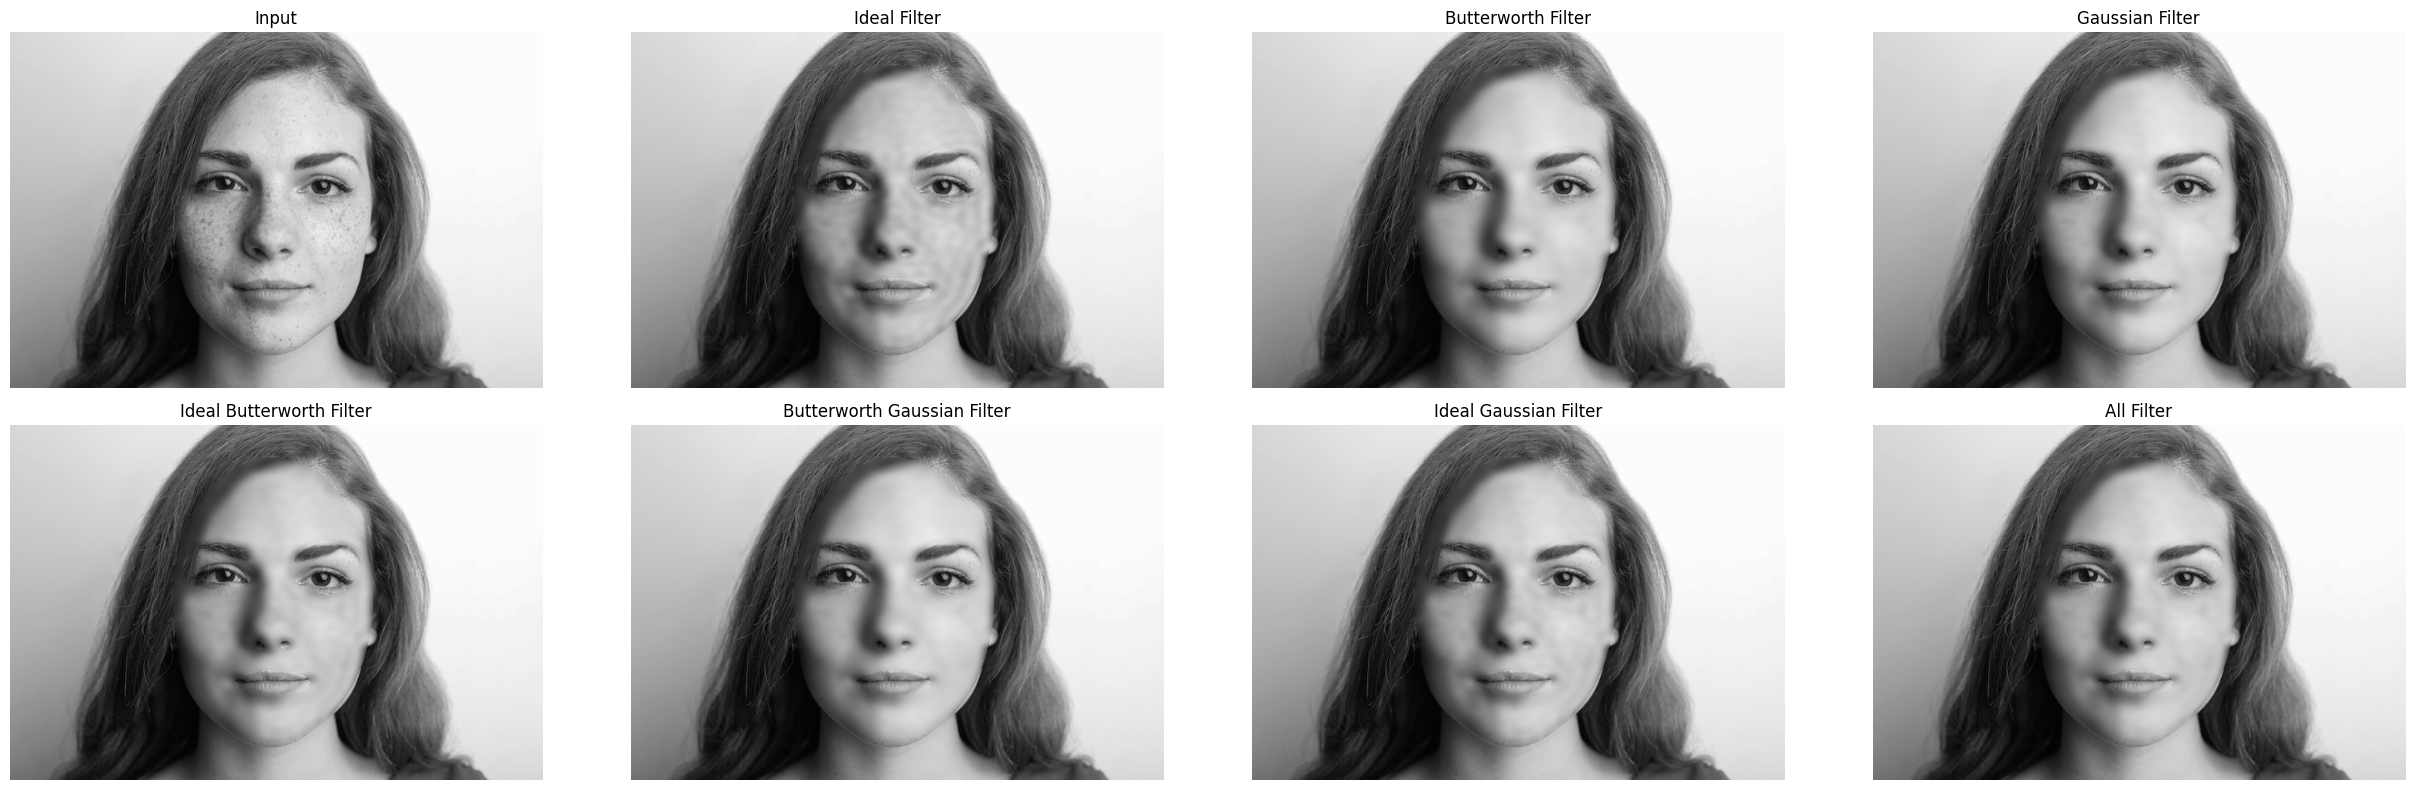

In [11]:
# Display results
plt.figure(figsize=(25, 8))

plt.subplot(2, 4, 1)
plt.title("Input")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 2)
plt.title("Ideal Filter")
plt.imshow(ideal_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 3)
plt.title("Butterworth Filter")
plt.imshow(butterworth_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 4)
plt.title("Gaussian Filter")
plt.imshow(gaussian_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 5)
plt.title("Ideal Butterworth Filter")
plt.imshow(ideal_butterworth_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 6)
plt.title("Butterworth Gaussian Filter")
plt.imshow(butterworth_gaussian_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 7)
plt.title("Ideal Gaussian Filter")
plt.imshow(ideal_gaussian_filtered, cmap='gray')
plt.axis("off")

plt.subplot(2, 4, 8)
plt.title("All Filter")
plt.imshow(img_filtered, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.savefig("img/result of image.jpg")
plt.show()